
# REBEL

In [5]:
from transformers import pipeline
import textwrap
import networkx as nx
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import matplotlib.pyplot as plt

In [3]:
from SPARQLWrapper import SPARQLWrapper, JSON

def get_dbpedia_abstract(resource_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    # Query to fetch the abstract of a resource from DBpedia
    query = f"""
    SELECT ?abstract
    WHERE {{
        <http://dbpedia.org/resource/{resource_name}> dbo:abstract ?abstract .
        FILTER (langMatches(lang(?abstract), 'en'))
    }}
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        abstracts = results["results"]["bindings"]
        
        if abstracts:
            return abstracts[0]["abstract"]["value"]
        else:
            return "Abstract not found for the resource."
    except Exception as e:
        return f"Error: {str(e)}"

resource_name = "Captain_America:_The_First_Avenger"
abstract = get_dbpedia_abstract(resource_name)
print(abstract)

Captain America: The First Avenger is a 2011 American superhero film based on the Marvel Comics character Captain America. Produced by Marvel Studios and distributed by Paramount Pictures, it is the fifth film in the Marvel Cinematic Universe (MCU). The film was directed by Joe Johnston, written by Christopher Markus and Stephen McFeely, and stars Chris Evans as Steve Rogers / Captain America alongside Tommy Lee Jones, Hugo Weaving, Hayley Atwell, Sebastian Stan, Dominic Cooper, Toby Jones, Neal McDonough, Derek Luke, and Stanley Tucci. During World War II, Steve Rogers, a frail man, is transformed into the super-soldier Captain America and must stop the Red Skull (Weaving) from using the Tesseract as an energy source for world domination. The film began as a concept in 1997 and was scheduled for distribution by Artisan Entertainment. However, a lawsuit disrupted the project and was not settled until September 2003. In 2005, Marvel Studios received a loan from Merrill Lynch, and planne

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [8]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [9]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [10]:
kb = from_text_to_kb(abstract, verbose=True)
kb.print()

Input has 399 tokens
Input has 4 spans
Span boundaries are [[0, 128], [90, 218], [180, 308], [270, 398]]
Relations:
  {'head': 'Captain America', 'type': 'instance of', 'tail': 'superhero film', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'publisher', 'tail': 'Marvel Comics', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'conflict', 'tail': 'World War II', 'meta': {'spans': [[0, 128], [90, 218]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Chris Evans', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Tommy Lee Jones', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Hugo Weaving', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Hayley Atwell', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Captain America', 'type': 'performer', 'tail': 'Sebastian Stan', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Capt

In [11]:
G = nx.DiGraph()

relation = {}
k = 0
for i, elem in enumerate(kb.relations):
    if elem['tail'] not in relation:
        relation[elem['tail']] = k
        G.add_node(k, name = relation[elem['tail']])
        k += 1
        
    if elem['head'] not in relation:
        relation[elem['head']] = k
        G.add_node(k, name=elem['head'])
        k += 1

    G.add_edge(relation[elem['head']], relation[elem['tail']], name = elem['type'])

In [18]:
print(inv_map)

{0: 'superhero film', 1: 'Captain America', 2: 'Marvel Comics', 3: 'World War II', 4: 'Chris Evans', 5: 'Tommy Lee Jones', 6: 'Hugo Weaving', 7: 'Hayley Atwell', 8: 'Sebastian Stan', 9: 'Dominic Cooper', 10: 'Toby Jones', 11: 'Neal McDonough', 12: 'Derek Luke', 13: 'Stanley Tucci', 14: 'Steve Rogers / Captain America', 15: 'Steve Rogers', 16: 'Marvel Studios', 17: 'Jon Favreau', 18: 'Louis Leterrier', 19: 'Paramount Pictures', 20: 'July 19, 2011', 21: 'Captain America: The First Avenger', 22: 'visual effects', 23: 'Lola', 24: 'Phase One of the MCU'}


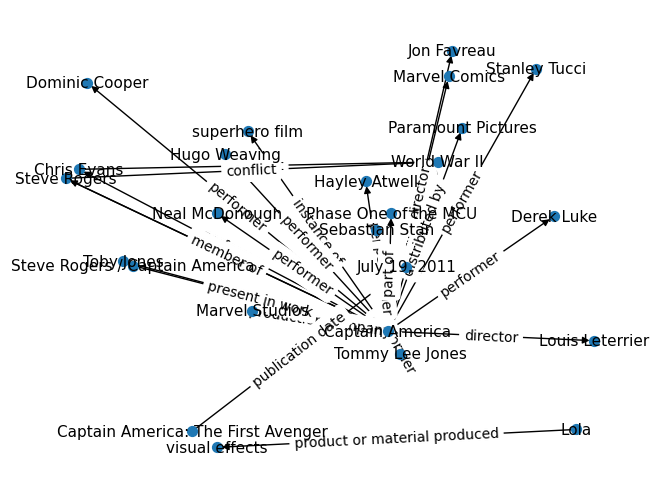

In [12]:
inv_map = {v: k for k, v in relation.items()}
pos = nx.random_layout(G)
edge_labels = dict([((n1, n2), d['name'])
                    for n1, n2, d in G.edges(data=True)])

options = {
    'labels':inv_map,
    'with_labels':True,
    'node_size': 50,
    'pos': pos,
    'font_size':11
}

nx.draw(G, **options)
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
plt.show()

In [38]:
from rdflib import Graph, Literal, Namespace
from rdflib import RDF

g = Graph()
ns = Namespace("http://projet.fr/text/")

In [39]:
for node in G.nodes():
    node = inv_map.get(node).replace(' ','_')
    g.add((ns[node], RDF.type, ns['Node']))  # Example mapping node to RDF type 'Node'

In [40]:
for edge in G.edges(data=True):
    print(edge)
    source, target, data = edge
    source = inv_map.get(source).replace(' ','_')
    target = inv_map.get(target).replace(' ','_')
    g.add((ns[source], ns[data['name'].replace(" ","_")], ns[target]))  # Example mapping edge connection


(1, 0, {'name': 'instance of'})
(1, 2, {'name': 'publisher'})
(1, 3, {'name': 'conflict'})
(1, 4, {'name': 'performer'})
(1, 5, {'name': 'performer'})
(1, 6, {'name': 'performer'})
(1, 7, {'name': 'performer'})
(1, 8, {'name': 'performer'})
(1, 9, {'name': 'performer'})
(1, 10, {'name': 'performer'})
(1, 11, {'name': 'performer'})
(1, 12, {'name': 'performer'})
(1, 13, {'name': 'performer'})
(1, 15, {'name': 'has part'})
(1, 16, {'name': 'production company'})
(1, 17, {'name': 'director'})
(1, 18, {'name': 'director'})
(1, 19, {'name': 'distributed by'})
(1, 24, {'name': 'part of'})
(4, 3, {'name': 'conflict'})
(14, 1, {'name': 'present in work'})
(15, 3, {'name': 'conflict'})
(15, 1, {'name': 'member of'})
(21, 20, {'name': 'publication date'})
(23, 22, {'name': 'product or material produced'})


In [41]:
g.serialize(destination="extracted_text.ttl", format="turtle")

<Graph identifier=N4621e77a018f48a8b568964f34a5a35c (<class 'rdflib.graph.Graph'>)>